In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader
print(tf.__version__)

2.4.1


In [ ]:
image_size = (224, 224)
# image_size = (600, 600)

batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/Train",
    seed=1337,
    label_mode = 'categorical',
    image_size=image_size,
    batch_size=batch_size,
    labels = "inferred"
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/Test",
    seed=1337,
    image_size=image_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/Validation",
    seed=1337,
    label_mode = 'categorical',
    image_size=image_size,
    batch_size=batch_size,
    labels = "inferred"
)




Found 774 files belonging to 2 classes.
Found 90 files belonging to 2 classes.
Found 99 files belonging to 2 classes.


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def resnet_model(input_shape, num_classes):
    # inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    # x = data_augmentation(inputs)
    base_model = keras.applications.ResNet50(weights='imagenet', input_shape=input_shape)
    out_resnet = base_model.output
    res = layers.Dropout(0.5)(out_resnet)
    output = layers.Dense(num_classes, activation='sigmoid', name='sigmoid')(res)
    net_final = keras.Model(inputs=base_model.input, outputs=output)

    return net_final

resnet_model = resnet_model(input_shape=image_size + (3,), num_classes=2)
resnet_model.compile(
    optimizer=keras.optimizers.RMSprop(lr=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy",f1_m,precision_m, recall_m]
)
# resnet_model.summary()

callbacked = [keras.callbacks.ModelCheckpoint("/content/gdrive/Shareddrives/ComED Codes and Data/model_weights/resnet_{epoch}.h5")]

In [ ]:
# keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 25

res_model = resnet_model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacked)

Epoch 1/25
25/25 [==============================] - 308s 7s/step - loss: 0.6848 - accuracy: 0.7381 - f1_m: 0.7303 - precision_m: 0.7472 - recall_m: 0.7160 - val_loss: 0.6742 - val_accuracy: 0.8990 - val_f1_m: 0.9219 - val_precision_m: 0.9219 - val_recall_m: 0.9219
Epoch 2/25
25/25 [==============================] - 12s 431ms/step - loss: 0.6723 - accuracy: 0.8459 - f1_m: 0.8465 - precision_m: 0.8444 - recall_m: 0.8487 - val_loss: 0.6719 - val_accuracy: 0.9192 - val_f1_m: 0.9375 - val_precision_m: 0.9375 - val_recall_m: 0.9375
Epoch 3/25
25/25 [==============================] - 12s 432ms/step - loss: 0.6708 - accuracy: 0.8163 - f1_m: 0.8160 - precision_m: 0.8159 - recall_m: 0.8161 - val_loss: 0.6721 - val_accuracy: 0.8788 - val_f1_m: 0.9020 - val_precision_m: 0.9057 - val_recall_m: 0.8984
Epoch 4/25
25/25 [==============================] - 12s 428ms/step - loss: 0.6653 - accuracy: 0.8556 - f1_m: 0.8568 - precision_m: 0.8556 - recall_m: 0.8580 - val_loss: 0.6712 - val_accuracy: 0.8485 - 

In [ ]:
import matplotlib.pyplot as plt

def plot_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(acc)+1)
    
    plt.plot(epochs,acc,'-',label='Training acc')
    plt.plot(epochs,val_acc,'-',label='Validation acc',color ="orange")
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.savefig("acc.png", dpi = 300)
    
    plt.figure()
    plt.plot(epochs,loss,'-',label='Training loss')
    plt.plot(epochs,val_loss,'-',label='Validation loss',color ="orange")
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.savefig("loss.png", dpi = 300)

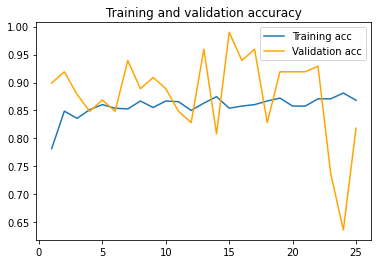

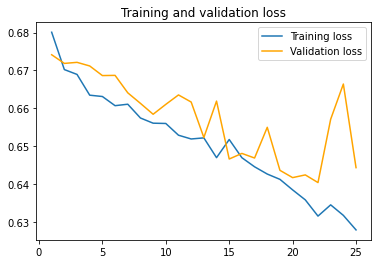

In [ ]:
plot_curve(res_model)

# approach 2 


In [ ]:
path_model="/content/gdrive/Shareddrives/ComED Codes and Data/model_weights/resnet_11.h5"
resnet_model.load_weights(path_model)

In [ ]:
import numpy as np

In [ ]:
def process_image(img):
  img = []
  x = []
  from keras.preprocessing import image
  x = image.img_to_array(i)
  # x = tf.image.rgb_to_grayscale(x)
  x = np.expand_dims(x, axis=0)
  img.append(x)


  x = np.concatenate([x for x in img])
  return x


done!


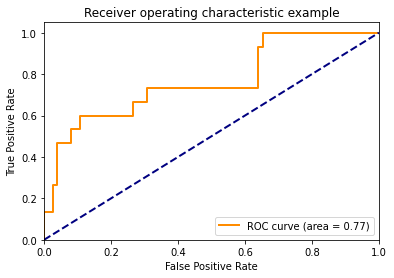

In [ ]:
predict_prob = []
label_list = []
for i, j in test_ds.unbatch():
  processed_image = process_image(i)
  pred = resnet_model.predict(processed_image)[0][1]
  label_list.append(j)
  predict_prob.append(pred)

print("done!")

from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(label_list, predict_prob)
roc_auc= auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(label_list, predict_prob)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.53


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()

precision, recall, _ = precision_recall_curve(label_list, predict_prob)

import plotly.express as px
fig = px.line(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()